In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd

from sklearn.mixture import GaussianMixture

In [2]:
from torch_geometric.loader import DataLoader
import umap

In [3]:
%cd ../..

/nfs/homedirs/fuchsgru/MastersThesis


In [4]:
import configuration
import model_registry
import data.construct
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions, get_distribution_labels
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model


In [5]:
cpkt_path = '/nfs/students/fuchsgru/model_registry/3170399287.ckpt' # No inductive biases

registry = model_registry.ModelRegistry()
# Find a cnfg for that checkpoint
for config, path in registry.items():
    if path == cpkt_path:
        break
else:
    raise RuntimeError(f'Could not find a configuration for {cpkt_path}')

In [6]:
data_list, fixed_vertices = data.construct.load_data_from_configuration(config.data, 1)
        

In [7]:
data_dict = data_list[0]
data_loaders = {
        name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

In [8]:
model = SemiSupervisedNodeClassification(
    config.model, 
    data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]), 
    learning_rate=config.training.learning_rate,
    weight_decay=config.training.weight_decay,
)

In [9]:
idx_to_label = {idx : label for label, idx in data_dict[dconst.TRAIN][0].label_to_idx.items()}

In [10]:
ckpt_path = registry[config]
if not ckpt_path:
    raise RuntimeError(f'No model checkpoint found!')

In [11]:
model = model.load_from_checkpoint(ckpt_path, strict=False)
_ = model.eval()

In [12]:
W_out = model.backbone.get_output_weights()
with torch.no_grad():
    features, predictions, labels, mask, logits = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.VAL]], gpus=0, model_kwargs={},
        callbacks = [
            ecbs.make_callback_get_features(mask = False),
            ecbs.make_callback_get_predictions(mask = False),
            ecbs.make_callback_get_ground_truth(mask = False),
            ecbs.make_callback_get_mask(mask = False),
            ecbs.make_callback_get_logits(mask = False),
        ]
    )]


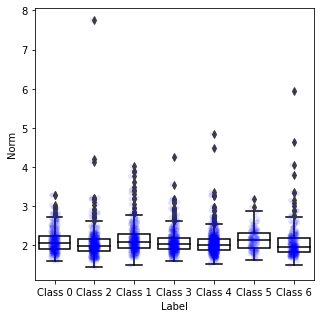

In [114]:
def plot_norms(norm, y, y_labels=None, norm_label='Norm', **kwargs):
    if y_labels is None:
        y_labels = {i : f'Class {i}' for i in np.unique(y)}
    fig, ax = plt.subplots(**kwargs)
    data = pd.DataFrame({
        'Label' : [y_labels[i] for i in y],
        norm_label : norm,
    })
    sns.stripplot(data = data, ax=ax, x='Label', y=norm_label, alpha=0.1, size=5, color='blue')
    sns.boxplot(data = data, ax=ax, x='Label', y=norm_label, 
                **{
                    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
                    'medianprops':{'color':'black'},
                    'whiskerprops':{'color':'black'},
                    'capprops':{'color':'black'}
    })
    # ax.set_xticks(())
plot_norms(x_norm, labels.cpu().numpy(), figsize=(5, 5))

(<Figure size 1080x864 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'Weights Class 0'}, xlabel='Label', ylabel='Cosine'>,
         <AxesSubplot:title={'center':'Weights Class 1'}, xlabel='Label', ylabel='Cosine'>,
         <AxesSubplot:title={'center':'Weights Class 2'}, xlabel='Label', ylabel='Cosine'>],
        [<AxesSubplot:title={'center':'Weights Class 3'}, xlabel='Label', ylabel='Cosine'>,
         <AxesSubplot:title={'center':'Weights Class 4'}, xlabel='Label', ylabel='Cosine'>,
         <AxesSubplot:title={'center':'Weights Class 5'}, xlabel='Label', ylabel='Cosine'>],
        [<AxesSubplot:title={'center':'Weights Class 6'}, xlabel='Label', ylabel='Cosine'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

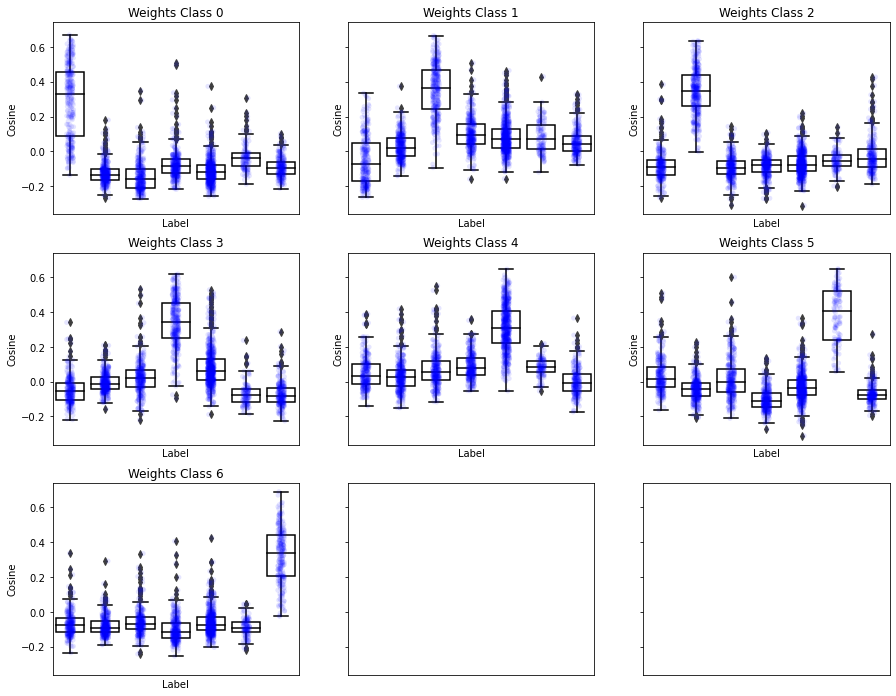

In [108]:
def plot_logit_cosine_angles(cos_angles, y, y_labels=None, rows=None, cols=3, **kwargs):
    """ Plots the cosine of angles between features and logit weights as boxplots. 
    
    Parameters:
    -----------
    cos_angles : ndarray, shape [N, num_classes]
        Angle between each vertex feature and the corresponding logit weight.
    y : ndarray, shape [N]
        Labels for each vertex
    y_labels : dict or None
        Names for the labels.
    """
    if y_labels is None:
        y_labels = {i : f'Class {i}' for i in np.unique(y)}
    if rows is None:
        rows = int(np.around((cos_angles.shape[1] / cols) + .5))
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, **kwargs)
    for label, ax in enumerate(axs.flatten()):
        if label >= cos_angles.shape[1]:
            pass
        else:
            ax.set_title(f'Weights {y_labels[label]}')
            data = pd.DataFrame({
                'Label' : [y_labels[i] for i in y],
                'Cosine' : cos_angles[:, label],
            })
            sns.stripplot(data = data, ax=ax, x='Label', y='Cosine', alpha=0.1, size=5, color='blue')
            sns.boxplot(data = data, ax=ax, x='Label', y='Cosine', 
                        **{
                            'boxprops':{'facecolor':'none', 'edgecolor':'black'},
                            'medianprops':{'color':'black'},
                            'whiskerprops':{'color':'black'},
                            'capprops':{'color':'black'}
            })
            ax.set_xticks(())
    
    return fig, axs
    
    
    
    
    
plot_logit_cosine_angles(cosine_similarity(x, w), labels.cpu().numpy(), figsize=(15, 12))    

In [50]:

from sklearn.metrics.pairwise import cosine_similarity

# The logits are calculated as l = Conv(linear(X)) = Conv(W x X + b)
# This W x X (before aggregation)

x = features.numpy()
w = model.backbone.get_output_weights().numpy()
cos = cosine_similarity(x, w)
x_norm = np.linalg.norm(x, ord=2, axis=-1)
w_norm = np.linalg.norm(w, ord=2, axis=-1)







In [ ]:

df = pd.DataFrame({
    'Cosine' : cos.flatten(),
    'Norm Weights' : w_norm[None, :].repeat(x_norm.shape[0], axis=0).flatten(),
    'Norm Features' : x_norm[:, None].repeat(w_norm.shape[-1], axis=-1).flatten(),
    'Label' : labels.cpu().numpy()[:, None].repeat(w_norm.shape[-1], axis=-1).flatten(),
    'Class' : np.arange(7)[None, :].repeat(x_norm.shape[0], axis=0).flatten(),
}).melt(id_vars=['Class', 'Label'], var_name='Kind', value_name='Value')

sns.catplot(data=df, kind='box', col='Kind', row='Class', x='Label', y='Value')

In [49]:
w_norm

array([[3.8025591, 4.0705814, 4.0001397, 4.0418644, 4.1225295, 4.044821 ,
        3.9089453]], dtype=float32)

In [42]:
.shape

(17101,)

In [13]:
logits.squeeze().size()

torch.Size([2443, 7])

In [14]:
x = features.numpy()
w = model.backbone.get_output_weights().numpy()

cos = cosine_similarity(x, w)
x_norm = np.linalg.norm(x, ord=2, axis=-1)[:, None]
w_norm = np.linalg.norm(w, ord=2, axis=-1)[None, :]
cos.shape, x_norm.shape, w_norm.shape


((2443, 7), (2443, 1), (1, 7))

In [13]:
with torch.no_grad():
    features, predictions, labels, mask, logits = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.VAL]], gpus=0, model_kwargs={},
        callbacks = [
            ecbs.make_callback_get_features(mask = False),
            ecbs.make_callback_get_predictions(mask = False),
            ecbs.make_callback_get_ground_truth(mask = False),
            ecbs.make_callback_get_mask(mask = False),
            ecbs.make_callback_get_logits(mask = False),
        ]
    )]
    
    mask_train, = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.TRAIN]], gpus=0, model_kwargs={}, run_model=False,
        callbacks = [
            ecbs.make_callback_get_mask(mask = False),
        ]
    )]
    
with torch.no_grad():
    features_ood, predictions_ood, labels_ood, mask_ood_val, logits_ood = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.OOD_VAL]], gpus=0, model_kwargs={},
        callbacks = [
            ecbs.make_callback_get_features(mask = True),
            ecbs.make_callback_get_predictions(mask = True),
            ecbs.make_callback_get_ground_truth(mask = True),
            ecbs.make_callback_get_mask(mask = True),
            ecbs.make_callback_get_logits(mask = True),
        ]
    )]
    

In [14]:
predictions_train_orig = predictions.clone()
predictions[mask_train] = label_binarize(labels[mask_train], num_classes=predictions.size(1)).float()
gnd_binarized = label_binarize(labels).float()[:, :predictions.size(1)]

In [15]:
proj = umap.UMAP(random_state = 1337)
_ = proj.fit(features.cpu().numpy())


In [16]:
proj_ood = umap.UMAP(random_state = 1337)
_ = proj_ood.fit(features_ood.cpu().numpy())


In [17]:
features_proj = proj.transform(features.cpu().numpy())
features_ood_proj = proj_ood.transform(features_ood.cpu().numpy())

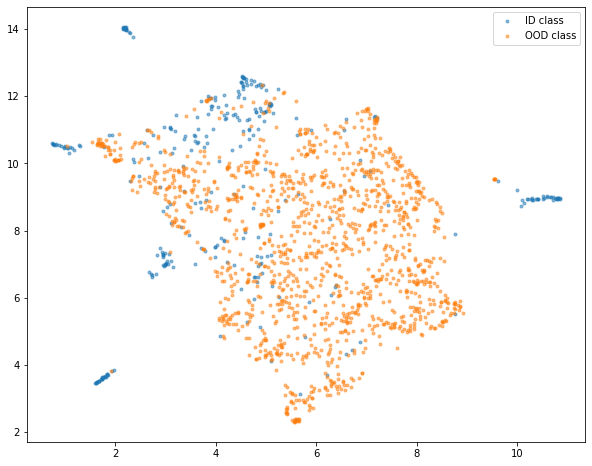

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mask_id_class = labels_ood < predictions_ood.size(1)
ax.scatter(
    features_ood_proj[mask_id_class][:, 0],
    features_ood_proj[mask_id_class][:, 1],
    alpha = 0.5,
    label='ID class',
    marker='.'
)
ax.scatter(
    features_ood_proj[~mask_id_class][:, 0],
    features_ood_proj[~mask_id_class][:, 1],
    alpha = 0.5,
    label='OOD class',
    marker='.'
)
ax.legend()

In [19]:
density_model = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model.fit(features[mask_train], predictions[mask_train])


e_ber                                                |   
density_model_all_graph.fit(features, predictions)

density_model_all_graph_best_prediction = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model_all_graph_best_prediction.fit(features, predictions * label_binarize(predictions.argmax(1)))


density_model_all_graph_best_prediction_99conf = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
predictions99conf = predictions * label_binarize(predictions.argmax(1))
predictions99conf[predictions99conf < .99] = 0.0
density_model_all_graph_best_prediction_99conf.fit(features, predictions99conf)

Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-

In [40]:
def plot_gpc_density(density_model):

    fig, axs = plt.subplots(3, 3, figsize=(20, 20))
    vmax = density_model(features)[~mask_train].cpu().numpy().max()
    

    for class_label in range(predictions.size(1)):
        ax = axs.flatten()[class_label]

        h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                    c=density_model.get_density_class(class_label, features)[~mask_train], vmin=-50, vmax=vmax)
        ax.scatter(
            features_proj[:, 0][(mask_train) & (labels == class_label)], 
            features_proj[:, 1][(mask_train) & (labels == class_label)], 
            label='train', marker='x', color='black')
        cbar = plt.colorbar(h, ax=ax)
        cbar.ax.set_ylabel('Log Density')
        mean_proj = proj.transform(density_model.means[class_label][None, :].cpu())
        ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
        real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
        ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Train Mean')
        ax.legend()
        ax.set_title(idx_to_label[class_label])
    
    
    
    # Whole model
    
    ax = axs.flatten()[predictions.size(1)]
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                    c=density_model(features)[~mask_train].numpy(), vmin=-50, vmax=vmax)
    ax.scatter(
            features_proj[:, 0][(mask_train) ], 
            features_proj[:, 1][(mask_train) ], 
            label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    ax.set_title('All classes')
    
    
    
    # OOD
    features_train_ood = proj_ood.transform(features[mask_train].cpu().numpy())
    ax = axs.flatten()[predictions.size(1) + 1]
    h = ax.scatter(features_ood_proj[:, 0][~mask_id_class], features_ood_proj[:, 1][~mask_id_class], alpha = .5, label='OOD class', 
                    c=density_model(features_ood)[~mask_id_class].numpy(), vmin=-50, vmax=vmax)
    ax.scatter(
            features_train_ood[:, 0], 
            features_train_ood[:, 1], 
            label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    ax.set_title('OOD')
    ax.legend()
    
    
    
    
    return fig, axs

(<Figure size 1440x1440 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Case-Based'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Theory'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Neural_Networks'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Rule_Learning'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'}>,
         <AxesSubplot:title={'center':'All classes'}>,
         <AxesSubplot:title={'center':'OOD'}>]], dtype=object))

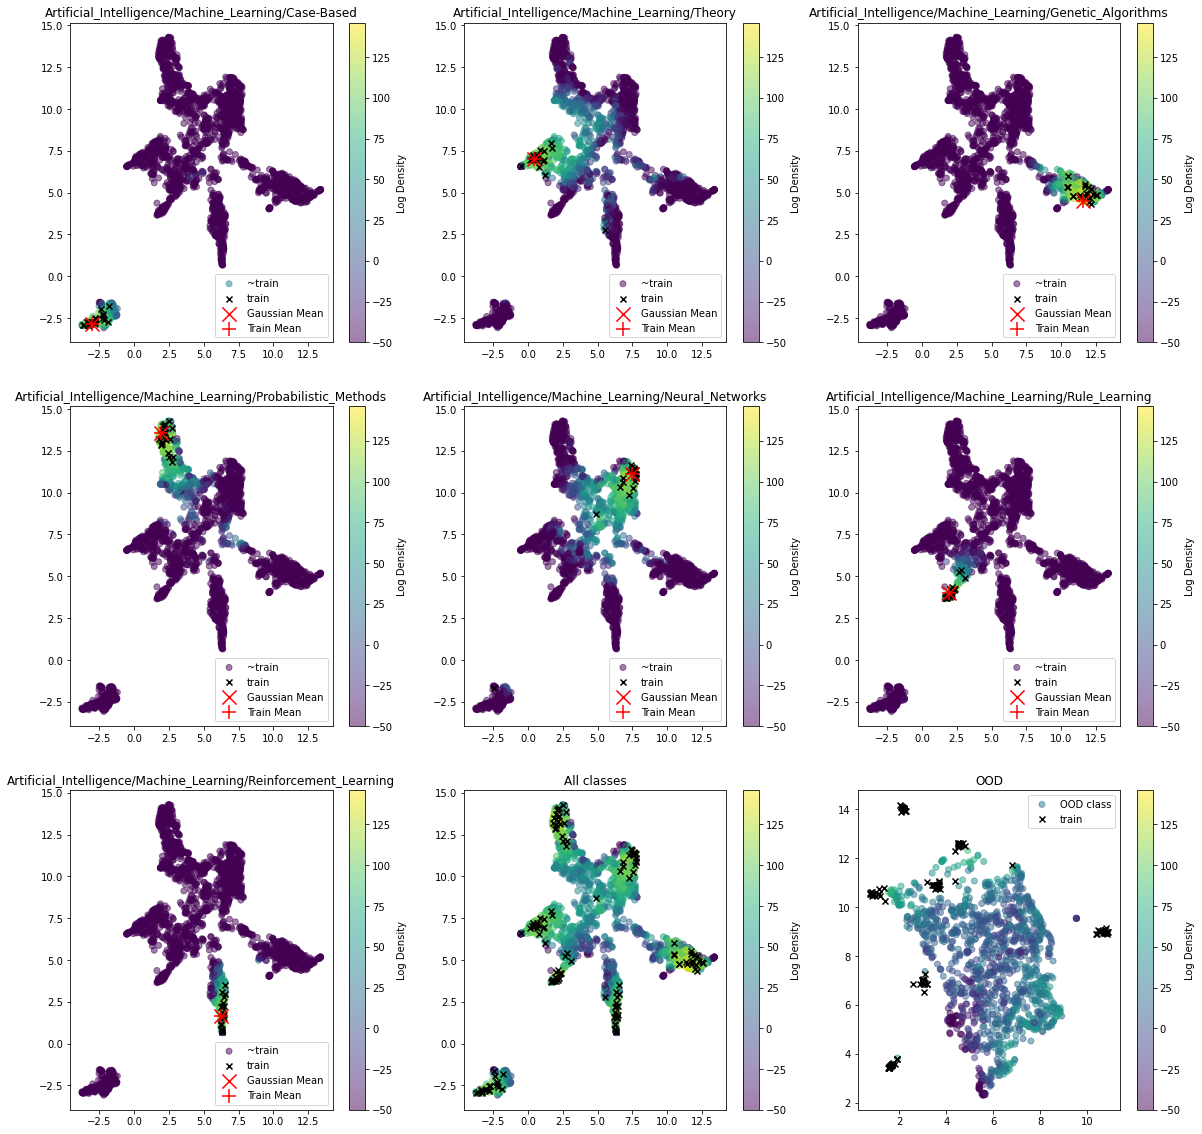

In [41]:
plot_gpc_density(density_model)

(<Figure size 1440x1440 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Case-Based'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Theory'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Neural_Networks'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Rule_Learning'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'}>,
         <AxesSubplot:title={'center':'All classes'}>,
         <AxesSubplot:title={'center':'OOD'}>]], dtype=object))

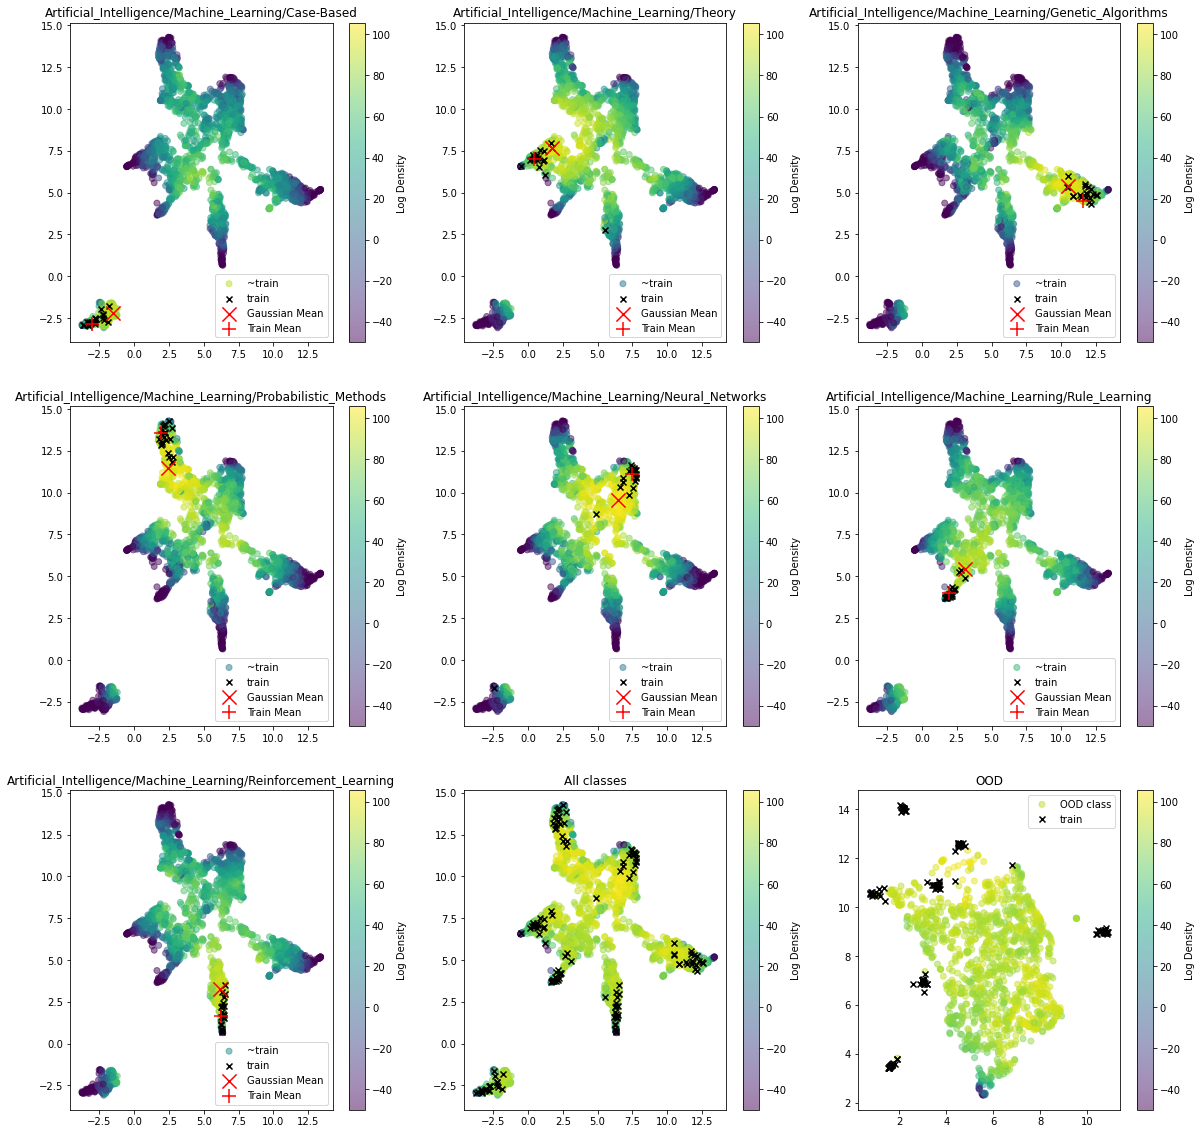

In [42]:
plot_gpc_density(density_model_all_graph)

(<Figure size 1440x1440 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Case-Based'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Theory'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Neural_Networks'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Rule_Learning'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'}>,
         <AxesSubplot:title={'center':'All classes'}>,
         <AxesSubplot:title={'center':'OOD'}>]], dtype=object))

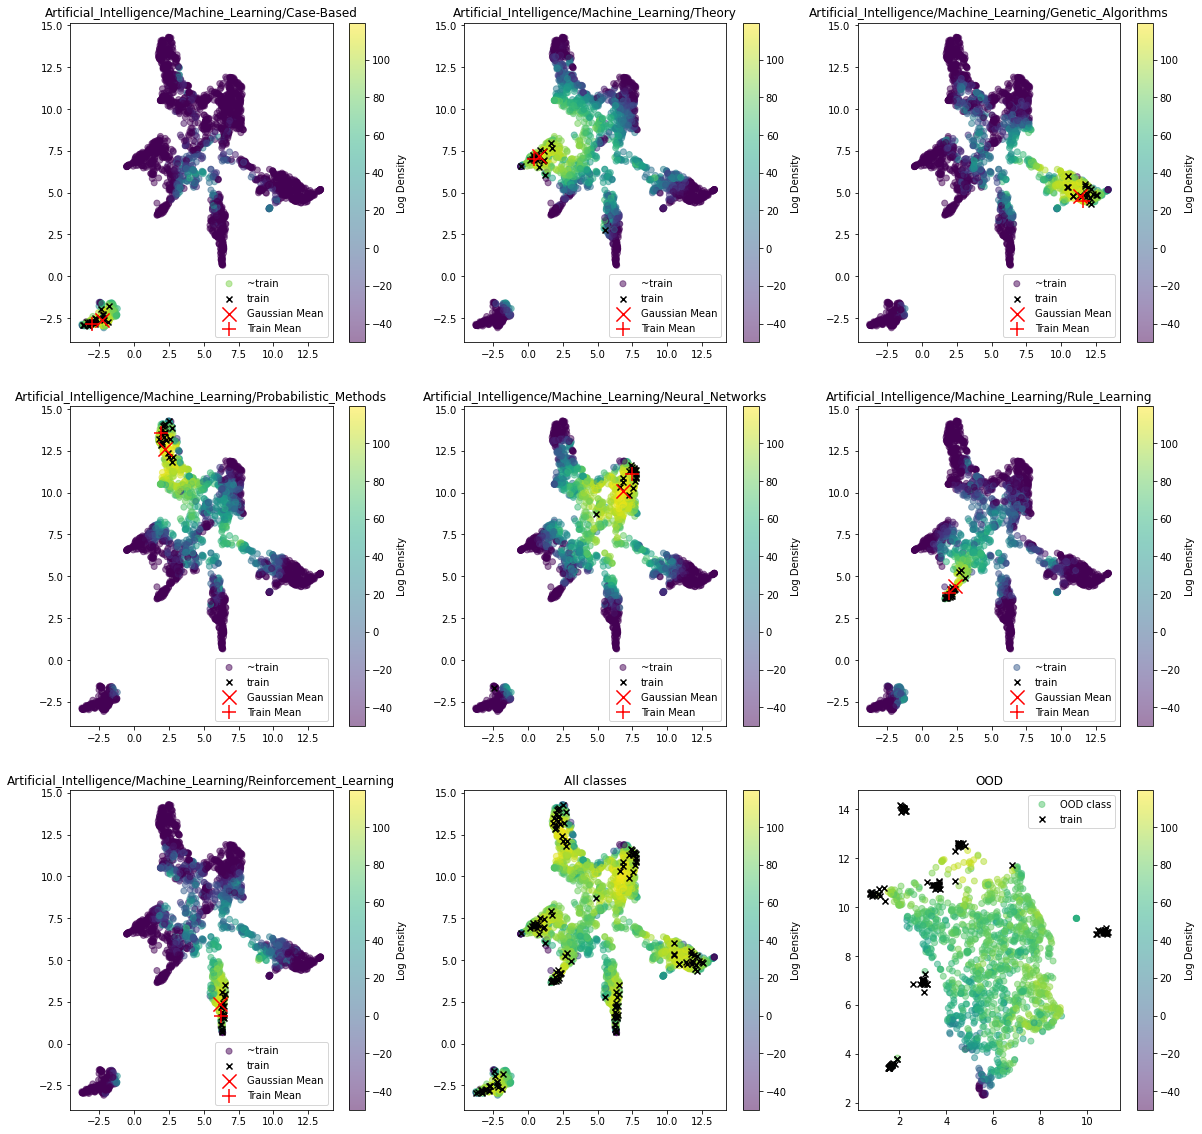

In [43]:
plot_gpc_density(density_model_all_graph_best_prediction)

((<Figure size 432x288 with 1 Axes>, <AxesSubplot:>), 0.19310692985015737)

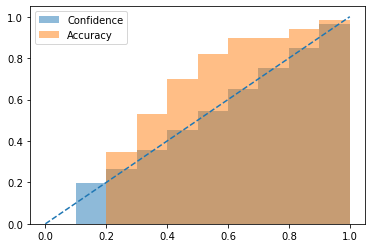

In [44]:

ece = expected_calibration_error(predictions[mask], labels[mask], bins=10, eps=1e-10)
plot_calibration(predictions, labels, bins=10, eps=1e-10), ece

(<Figure size 1440x1440 with 18 Axes>,
 array([[<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Case-Based'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Theory'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Neural_Networks'}>,
         <AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Rule_Learning'}>],
        [<AxesSubplot:title={'center':'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning'}>,
         <AxesSubplot:title={'center':'All classes'}>,
         <AxesSubplot:title={'center':'OOD'}>]], dtype=object))

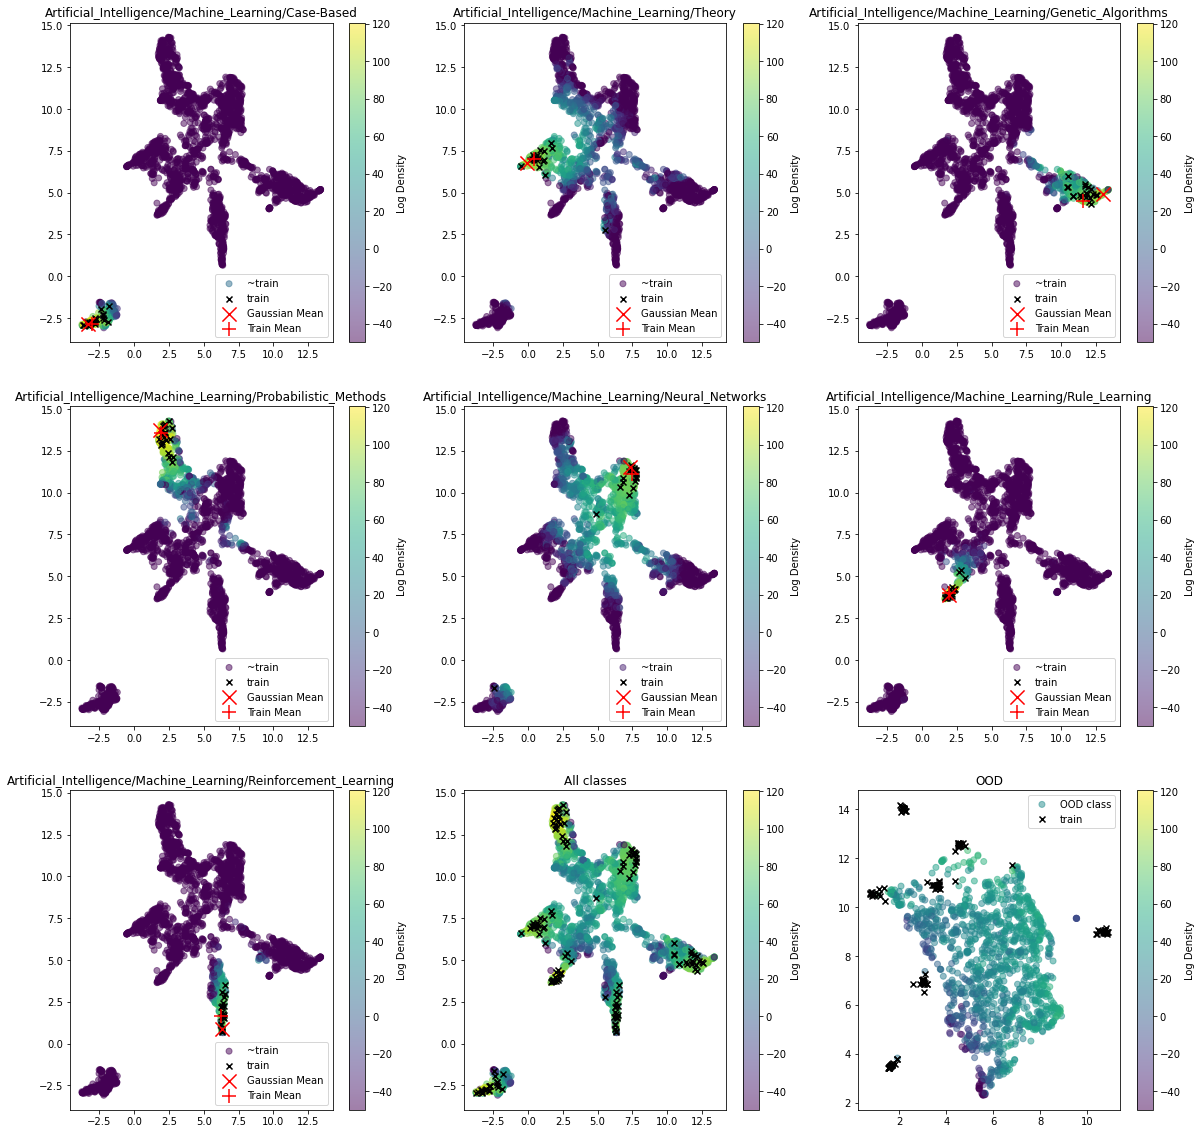

In [45]:
plot_gpc_density(density_model_all_graph_best_prediction_99conf)

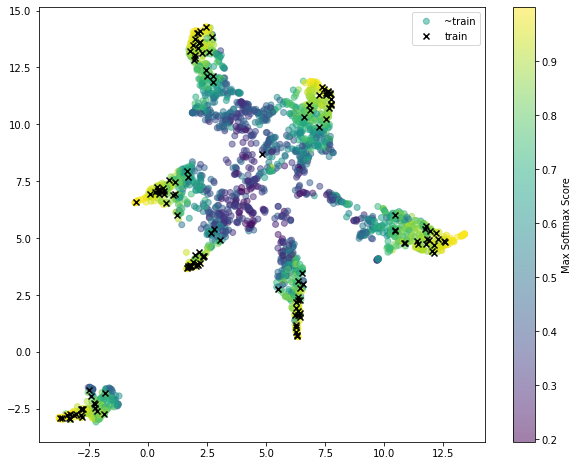

In [46]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', c=predictions.max(1)[0].numpy()[~mask_train])
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Max Softmax Score')
plt.legend()

In [50]:
density_model_mog = get_density_model(
                            density_type='GaussianMixture', 
                            diagonal_covariance=True,
                            initialization='predictions'
)
density_model_mog.fit(features[mask_train], predictions[mask_train])

Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.
Matrix not positive semi-definite. Adding 1e-06 to the diagnoal.


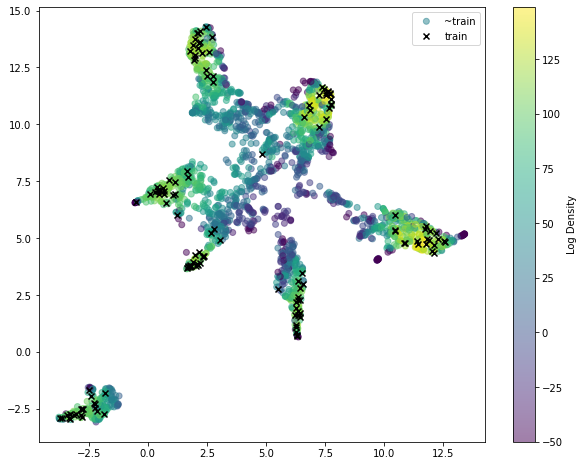

In [53]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_mog(features).cpu().numpy()[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

In [ ]:
density_model_nfpc = get_density_model(
                            density_type='NormalizingFlow', 
                            flow_type = 'maf',
                            num_layers = 10,
                            hidden_dim = features.size(1),
                            num_hidden = 2,
                            gpu = True,
                            verbose=True,
                            iterations='auto',
                            #mode='weighted',
                            weight_decay=1e-1,
)
density_model_nfpc.fit(features[mask_train], (predictions * label_binarize(predictions.argmax(1)))[mask_train])

In [ ]:
density_model_nfpc.evaluation_kwargs

In [ ]:
density_model_gmm = get_density_model(
                            density_type='GaussianMixture', 
                            diagonal_covariance=True,
                            number_components = predictions.size(1),
                            initialization = 'predictions',
)
density_model_gmm.fit(features, predictions)

In [ ]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_gmm(features)[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

In [ ]:
density_model = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model.fit(features[mask_train], predictions[mask_train])


density_model_all_graph = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model_all_graph.fit(features, predictions)

density_model_all_graph_best_prediction = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)
density_model_all_graph_best_prediction.fit(features, predictions * label_binarize(predictions.argmax(1)))


density_model_all_graph_best_prediction_99conf = get_density_model(
                            density_type='GaussianPerClass', 
                            diagonal_covariance=True,
                            prior=0,
)

predictions99conf = predictions * label_binarize(predictions.argmax(1))
predictions99conf[predictions99conf < .99] = 0.0
density_model_all_graph_best_prediction_99conf.fit(features, predictions99conf)


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    dc0 = density_model.get_density_class(class_label, features)
    _, bins, _ = ax.hist(dc0[(labels == class_label) & (mask_train)].numpy(), histtype=u'step', density=True, label='Class')
    ax.hist(dc0[(labels != class_label)  & (mask_train)].numpy(), bins=bins, histtype=u'step', density=True, label='~Class')
    ax.set_title(idx_to_label[class_label])
    ax.legend()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    is_fitted = mask_train & (labels == class_label)
    
    scatter = ax.scatter(features_proj[:, 0][~is_fitted], features_proj[:, 1][~is_fitted], 
                         c = (predictions - gnd_binarized)[:, class_label][~is_fitted], cmap = 'PiYG', label='Not fit', marker='o')
    _ = ax.scatter(features_proj[:, 0][is_fitted], features_proj[:, 1][is_fitted], 
                         color='black', label='Fit', marker='x', s=100, alpha=0.5)
    ax.legend()
    
    
    ax.set_title(idx_to_label[class_label])
    plt.colorbar(scatter, ax=ax)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    is_fitted = mask_train & (labels == class_label)
    
    scatter = ax.scatter(features_proj[:, 0][~is_fitted], features_proj[:, 1][~is_fitted], 
                         c = ((predictions * label_binarize(predictions.argmax(1))) - gnd_binarized)[:, class_label][~is_fitted], cmap = 'PiYG', label='Not fit', marker='o')
    _ = ax.scatter(features_proj[:, 0][is_fitted], features_proj[:, 1][is_fitted], 
                         color='black', label='Fit', marker='x', s=100, alpha=0.5)
    ax.legend()
    
    
    ax.set_title(idx_to_label[class_label])
    plt.colorbar(scatter, ax=ax)

In [ ]:
fig = plt.figure(figsize=(10, 8))
correct = labels == predictions.argmax(1)
conf = predictions.max(1)[0]
plt.scatter(features_proj[:, 0][correct], features_proj[:, 1][correct], label='correct', s=50)
plt.scatter(features_proj[:, 0][~correct], features_proj[:, 1][~correct], label='incorrect', alpha = conf[~correct])
plt.legend()

In [ ]:
fig = plt.figure(figsize=(10, 8))
plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], label='~train')
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train')
plt.legend()

In [ ]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', c=predictions.max(1)[0].numpy()[~mask_train])
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Max Softmax Score')
plt.legend()

In [ ]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model(features)[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

In [ ]:

plt.figure(figsize=(10, 8))
h = plt.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_max(features)[~mask_train], vmin=-50)
plt.scatter(features_proj[:, 0][mask_train], features_proj[:, 1][mask_train], label='train', marker='x', color='black')
cbar = plt.colorbar(h)
cbar.ax.set_ylabel('Log Density')
plt.legend()

In [ ]:
predictions[mask_train].sum(0)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model.get_density_class(class_label, features)[~mask_train], vmin=-50)
    ax.scatter(
        features_proj[:, 0][(mask_train) & (labels == class_label)], 
        features_proj[:, 1][(mask_train) & (labels == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    mean_proj = proj.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
    ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])

In [ ]:
density_model_all_graph_best_prediction_99conf

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(features_proj[:, 0][~mask_train], features_proj[:, 1][~mask_train], alpha = .5, label='~train', 
                c=density_model_all_graph_best_prediction_99conf.get_density_class(class_label, features)[~mask_train], vmin=-50)
    ax.scatter(
        features_proj[:, 0][(mask_train) & (labels == class_label)], 
        features_proj[:, 1][(mask_train) & (labels == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    mean_proj = proj.transform(density_model_all_graph_best_prediction_99conf.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    real_mean_proj = proj.transform(features[(mask_train) & (labels == class_label)].mean(0, keepdim=True).numpy())
    ax.scatter(real_mean_proj[:, 0], real_mean_proj[:, 1], s=200, marker='+', color='red', label='Train Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(
    density_model(features).numpy(),
    predictions.max(1)[0].numpy(),
    alpha = 0.5,
)
ax.set_xlim(left=-50, right=150)
ax.set_xlabel('Log Density')
ax.set_ylabel('Max Softmax Score')


In [ ]:
low_epi_high_alea = (density_model(features).numpy() < -50) & (predictions.max(1)[0].numpy() > 0.99)
low_epi_high_alea.sum()

In [ ]:
idx_to_vertex = {idx : vertex for vertex, idx in data_dict[dconst.TRAIN][0].vertex_to_idx.items()}

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(features_proj[~low_epi_high_alea][:, 0], features_proj[~low_epi_high_alea][:, 1],)
ax.scatter(features_proj[low_epi_high_alea][:, 0], features_proj[low_epi_high_alea][:, 1], marker='x', label='Low Epi, High Alea')
ax.legend()

In [ ]:
vertices_low_epi_high_alea = [idx_to_vertex[v] for v in np.where(low_epi_high_alea)[0]]


In [ ]:
vertices_low_epi_high_alea[0]

In [ ]:
vertex_to_idx_full.keys()

In [ ]:
import data.npz

In [ ]:
from tqdm import tqdm

In [ ]:
labels_low_epi_high_alea = [idx_to_label[i] for i in labels[low_epi_high_alea].tolist()]
conf_low_epi_high_alea = predictions[low_epi_high_alea].max(1)[0].tolist()

loader = np.load(data.npz.NpzDataset.raw_files[config['data']['dataset']], allow_pickle=True)
vertex_to_idx_full = {v : idx for idx, v in loader['idx_to_node'].item().items()}

text_low_epi_high_alea = [loader['attr_text'][vertex_to_idx_full[i]] for i in tqdm(vertices_low_epi_high_alea)]



In [ ]:
for label, conf, text in zip(labels_low_epi_high_alea, conf_low_epi_high_alea, text_low_epi_high_alea):
    print(f'Label {label}, {(conf * 100):.2f} % : {text}')
    

In [ ]:


ece = expected_calibration_error(predictions[mask], labels[mask], bins=10, eps=1e-10)
plot_calibration(predictions, labels, bins=10, eps=1e-10)

In [ ]:
ece

### Looking at LoC vertices

In [ ]:
with torch.no_grad():
    features_ood, predictions_ood, labels_ood, mask_ood_val, logits_ood = [torch.cat(x, 0) for x in run_model_on_datasets(
        model, [data_loaders[dconst.OOD_VAL]], gpus=0, model_kwargs={},
        callbacks = [
            ecbs.make_callback_get_features(mask = False),
            ecbs.make_callback_get_predictions(mask = False),
            ecbs.make_callback_get_ground_truth(mask = False),
            ecbs.make_callback_get_mask(mask = False),
            ecbs.make_callback_get_logits(mask = False),
        ]
    )]
    

In [ ]:
vertex_to_idx_ood = data_loaders[dconst.OOD_VAL].dataset[0].vertex_to_idx
idx_to_vertex_ood = {i : v for v, i in vertex_to_idx_ood.items()}
mask_train_ood = torch.zeros(features_ood.size(0)).bool()
for idx_train in torch.where(mask_train)[0].numpy():
    mask_train_ood[vertex_to_idx_ood[idx_to_vertex[idx_train]]] = True



In [ ]:
proj_ood = umap.UMAP(random_state = 1337)
proj_ood.fit(features_ood.cpu().numpy())


In [ ]:
feature_ood_proj = proj_ood.transform(features_ood.cpu().numpy())

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mask_id_class = labels_ood < predictions_ood.size(1)
ax.scatter(
    feature_ood_proj[mask_id_class][:, 0],
    feature_ood_proj[mask_id_class][:, 1],
    alpha = 0.5,
    label='ID class',
    marker='.'
)
ax.scatter(
    feature_ood_proj[~mask_id_class][:, 0],
    feature_ood_proj[~mask_id_class][:, 1],
    alpha = 0.5,
    label='OOD class',
    marker='.'
)
ax.legend()

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (~mask_id_class) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        alpha = .5, label='OOD class', vmin=-200, vmax=100, marker='o')
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        alpha = .5, label='ID class', vmin=-200, vmax=100, marker='D')
    
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])
    

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (~mask_id_class) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (~mask_id_class) & mask_ood_val],
        alpha = .5, label='~train', vmin=-200, vmax=100)
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])
    

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in range(predictions.size(1)):
    ax = axs.flatten()[class_label]
    
    h = ax.scatter(
        feature_ood_proj[:, 0][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val], 
        feature_ood_proj[:, 1][(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        c=density_model.get_density_class(class_label, features_ood)[(~mask_train_ood) & (mask_id_class) & (labels_ood == class_label) & mask_ood_val],
        alpha = .5, label='~train', vmin=-200, vmax=100)
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(h, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='red', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])
    

In [ ]:
mins, maxs = feature_ood_proj.min(0), feature_ood_proj.max(0)
mins, maxs = mins - 0.1 * (maxs - mins), maxs + 0.05 * (maxs - mins) # Gives a margin for the density map
xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100), np.linspace(mins[1], maxs[1], 100), indexing='ij')
xx, yy = xx.reshape((-1, 1)), yy.reshape((-1, 1))
grid = np.concatenate((xx, yy), axis=-1)
grid_inv = proj_ood.inverse_transform(grid)

In [ ]:
xx, yy, density_grid = xx.reshape((bins_x, bins_y)), yy.reshape((bins_x, bins_y)), density_grid.reshape((bins_x, bins_y))

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

for class_label in (range(predictions.size(1))):
    ax = axs.flatten()[class_label]
    density_grid = density_model.get_density_class(class_label, torch.from_numpy(grid_inv))
    c = ax.contourf(
        xx.reshape((100, 100)), 
        yy.reshape((100, 100)), 
        density_grid.numpy().reshape((100, 100)), cmap='Reds', levels=np.linspace(-300, 100, 21), extend='both')
    ax.scatter(
        feature_ood_proj[:, 0][(mask_train_ood) & (labels_ood == class_label)], 
        feature_ood_proj[:, 1][(mask_train_ood) & (labels_ood == class_label)], 
        label='train', marker='x', color='black')
    cbar = plt.colorbar(c, ax=ax)
    cbar.ax.set_ylabel('Log Density')
    
    mean_proj = proj_ood.transform(density_model.means[class_label][None, :].cpu())
    ax.scatter(mean_proj[:, 0], mean_proj[:, 1], s=200, marker='x', color='Green', label='Gaussian Mean')
    ax.legend()
    ax.set_title(idx_to_label[class_label])


In [ ]:
density_grid

In [ ]:
density_grid = density_model(torch.tensor(proj.inverse_transform(grid)).float()).cpu().numpy()
        xx, yy, density_grid = xx.reshape((bins_x, bins_y)), yy.reshape((bins_x, bins_y)), density_grid.reshape((bins_x, bins_y))

In [ ]:
plt.hist((predictions_ood[mask_train_ood].max(1)[0] - predictions_train_orig.max(1)[0][mask_train]).numpy())

In [ ]:
[idx_to_vertex[i] for i in  torch.where(mask_train)[0].numpy()]